In [1]:
%matplotlib inline

import pandas as pd
import intake
catalog = intake.cat.access_nri
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import pandas as pd

from dask.distributed import Client, progress

import sys, os

os.chdir(os.path.join(os.getcwd(), "ACCESS-OM2-updated/figures/hovmoller_temp_depth"))
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## To deal with memory issues:
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.6.43.39:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.6.43.39:8786 --local-directory /local/g40/aek156`
* Then, make sure the following cell matches the scheduler address.

In [3]:
client = Client("tcp://10.6.43.39:8786")
client

<Client: 'tcp://10.6.1.23:8786' processes=1 threads=48, memory=188.56 GiB>

In [16]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']


cat_subset = catalog[expt]
var_search = cat_subset.search(variable='temp', frequency='1 monthly')
darray = var_search.to_dask()
darray = darray['temp']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
temp = darray

## This is the correct way to do this plot, but I don't have the right WOA13 data for now, 
# so am creating an alternative way for 1° output 
cat_subset = catalog['woa13/10_KDS50']
var_search = cat_subset.search(variable='temp')
darray = var_search.to_dask()
darray = darray['temp']
temp_WOA13 = darray.mean('time')

# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13 = temp_WOA13.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13['st_ocean'] = temp.st_ocean
temp_WOA13['xt_ocean'] = temp.xt_ocean
temp_WOA13['yt_ocean'] = temp.yt_ocean
temp_WOA13 = temp_WOA13.astype(np.float32)

temp_anom = temp - temp_WOA13 - 273.15

cat_subset = catalog[expt]
var_search = cat_subset.search(variable='area_t')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
darray = darray['area_t']
area_t = darray
mask = temp.isel(time=0).copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
area = mask*area_t
area_sum = area.sum(['yt_ocean', 'xt_ocean']).load()

var =area_t*temp_anom
temp_hov = var.sum(['yt_ocean', 'xt_ocean']).load()
temp_hov_1deg = temp_hov/area_sum

IPython.display.clear_output()
temp_hov_1deg

VariableNotFoundError: No files were found containing 'temp' in the 'woa13/10_KDS50' experiment

In [19]:
%%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='temp', frequency='1 monthly')
darray = var_search.to_dask()
darray = darray['temp']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
temp = darray
cat_subset = catalog['woa13/025_KDS50']
var_search = cat_subset.search(variable='temp', frequency='1 monthly')
darray = var_search.to_dask()
darray = darray['temp']
temp_WOA13 = darray.mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13 = temp_WOA13.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13['st_ocean'] = temp.st_ocean
temp_WOA13['xt_ocean'] = temp.xt_ocean
temp_WOA13['yt_ocean'] = temp.yt_ocean

temp_WOA13 = temp_WOA13.astype(np.float32)

temp_anom = temp - temp_WOA13 - 273.15

cat_subset = catalog[expt]
var_search = cat_subset.search(variable='area_t', frequency='1 monthly')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
darray = darray['area_t']
area_t = darray
mask = temp.isel(time=0).copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
area = mask*area_t
area_sum = area.sum(['yt_ocean', 'xt_ocean']).load()

var =area_t*temp_anom
temp_hov = var.sum(['yt_ocean', 'xt_ocean']).load()
temp_hov_025deg = temp_hov/area_sum

IPython.display.clear_output()

VariableNotFoundError: No files were found containing 'temp' in the 'woa13/025_KDS50' experiment

In [7]:
%%time
ekey='01deg'
chunks={'st_ocean':None, 'xt_ocean': 400, 'yt_ocean': 300}

expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

cat_subset = catalog[expt]
var_search = cat_subset.search(variable='temp')
darray = var_search.to_dask()
darray = darray['temp']
if offset:
    td = pd.Timedelta(days=offset)
    darray = darray.assign_coords(time=darray.time + td)
temp = darray
print(temp)

<xarray.DataArray 'temp' (time: 396, st_ocean: 75, yt_ocean: 2700,
                          xt_ocean: 3600)>
dask.array<concatenate, shape=(396, 75, 2700, 3600), dtype=float32, chunksize=(1, 7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1985-01-14T12:00:00 ... 2017-12-14T12:00:00
Attributes:
    long_name:      Potential temperature
    units:          degrees K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_iaf...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2019-04-12
    descri

In [8]:
%%time
cat_subset = catalog['woa13/01']
var_search = cat_subset.search(variable='temp')
darray = var_search.to_dask()
darray = darray['temp']
temp_WOA13 = darray.mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13 = temp_WOA13.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13['st_ocean'] = temp.st_ocean
temp_WOA13['xt_ocean'] = temp.xt_ocean
temp_WOA13['yt_ocean'] = temp.yt_ocean

# force calculation and save to disk -- we could probably skip the .load() and write directly
temp_WOA13.to_netcdf('/local/g40/amh157/woa13.nc')

VariableNotFoundError: No files were found containing 'temp' in the 'woa13/01' experiment

In [9]:
%%time
# rechunk to match ocean.nc data
temp_WOA13 = xr.open_dataset('/local/g40/amh157/woa13.nc', chunks=chunks).temp
temp_WOA13 = temp_WOA13.astype(np.float32)

temp_anom = temp - temp_WOA13 - 273.15
print(temp_anom)

FileNotFoundError: [Errno 2] No such file or directory: b'/local/g40/amh157/woa13.nc'

In [10]:
%%time
cat_subset = catalog[expt]
var_search = cat_subset.search(variable='area_t')
var_search = var_search.search(path=var_search.df['path'][0])
darray = var_search.to_dask()
darray = darray['area_t']
area_t = darray
mask = temp.isel(time=0).copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
area = mask*area_t
area_sum = area.sum(['yt_ocean', 'xt_ocean']).load()

CPU times: user 612 ms, sys: 79.1 ms, total: 691 ms
Wall time: 32.3 s


In [11]:
%%time
var =area_t*temp_anom
temp_hov = var.sum(['yt_ocean', 'xt_ocean'])

NameError: name 'temp_anom' is not defined

In [12]:
# This bit not working for me any longer?
#x=temp_hov.persist()
#progress(x)

In [13]:
%%time
temp_hov_01deg = temp_hov/area_sum
temp_hov_01deg.load()

NameError: name 'temp_hov' is not defined

In [14]:
%%time
#temp_hov.to_netcdf('/local/g40/amh157/temp_hov.nc')
#temp_hov_01deg.to_netcdf('/local/g40/amh157/temp_hov_01deg.nc')
temp_hov_01deg = xr.open_dataarray('/local/g40/amh157/temp_hov_01deg.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/local/g40/amh157/temp_hov_01deg.nc'

NameError: name 'temp_hov_1deg' is not defined

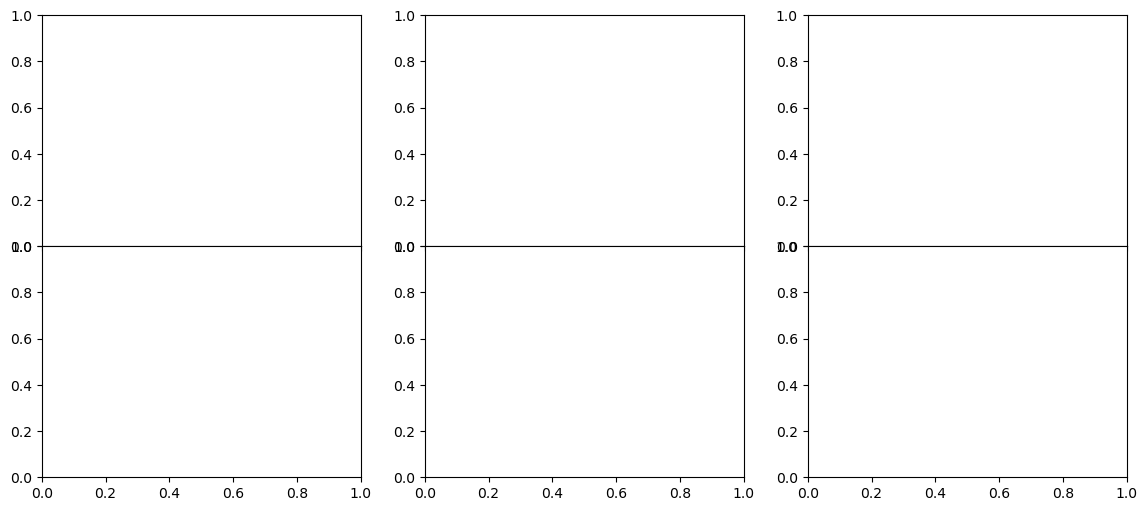

In [15]:
fig,ax = plt.subplots(2,3,sharex=True,figsize=(14,6))
plt.subplots_adjust(hspace=0)
levs = np.arange(-1.0,1.0001,0.05)

# 1deg
t_up = temp_hov_1deg.sel(st_ocean=slice(0,1000))
t_lo = temp_hov_1deg.sel(st_ocean=slice(1000,6000))

axx=ax[0,0]
t_up.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_title('(a) ACCESS-OM2')
axx=ax[1,0]
p1=t_lo.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('Depth (m)')
axx.set_xlabel('Year')

# 025deg
t_up = temp_hov_025deg.sel(st_ocean=slice(0,1000))
t_lo = temp_hov_025deg.sel(st_ocean=slice(1000,6000))

axx=ax[0,1]
t_up.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_xlabel('')
axx.set_title('(b) ACCESS-OM2-025')
plt.xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])
axx=ax[1,1]
p1=t_lo.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_xlabel('Year')
plt.xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])

# 01deg
t_up = temp_hov_01deg.sel(st_ocean=slice(0,1000))
t_lo = temp_hov_01deg.sel(st_ocean=slice(1000,6000))

axx=ax[0,2]
t_up.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_xlabel('')
plt.xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])
axx.set_title('(c) ACCESS-OM2-01')
axx=ax[1,2]
p1=t_lo.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_xlabel('Year')
plt.xlim([pd.Timestamp(1958,1,1),pd.Timestamp(2017,12,31)])

ax1 = plt.axes([0.92,0.25,0.015,0.5])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('°C')

savefigure('tz_hovmoller')